# Datenbeschaffung und -reinigung

In [20]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import Model
from keras._tf_keras.keras.models import load_model

In [8]:
dataset_path = 'Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

In [9]:

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

# Display the first few rows of the DataFrame
print(df.head())
print(df.tail())

                                            image    label
0      Rice_Image_Dataset\Arborio\Arborio (1).jpg  Arborio
1     Rice_Image_Dataset\Arborio\Arborio (10).jpg  Arborio
2    Rice_Image_Dataset\Arborio\Arborio (100).jpg  Arborio
3   Rice_Image_Dataset\Arborio\Arborio (1000).jpg  Arborio
4  Rice_Image_Dataset\Arborio\Arborio (10000).jpg  Arborio
                                                   image      label
74995  Rice_Image_Dataset\Karacadag\Karacadag (9995).jpg  Karacadag
74996  Rice_Image_Dataset\Karacadag\Karacadag (9996).jpg  Karacadag
74997  Rice_Image_Dataset\Karacadag\Karacadag (9997).jpg  Karacadag
74998  Rice_Image_Dataset\Karacadag\Karacadag (9998).jpg  Karacadag
74999  Rice_Image_Dataset\Karacadag\Karacadag (9999).jpg  Karacadag


# Explorative Datenanalyse (EDA)

## Analyse der Datenstrukturen

In [10]:
# Basic statistics about the dataset
print(df['label'].value_counts())

label
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64


## Erkennung von Mustern und Beziehungen

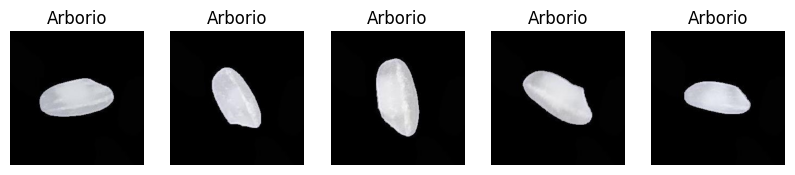

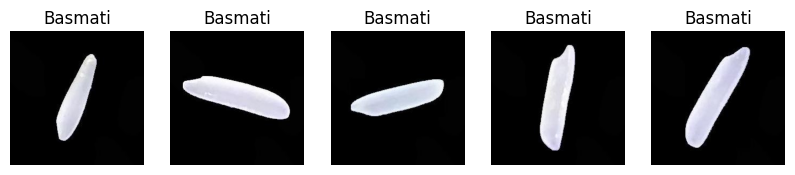

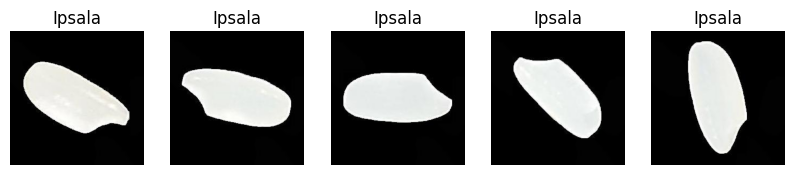

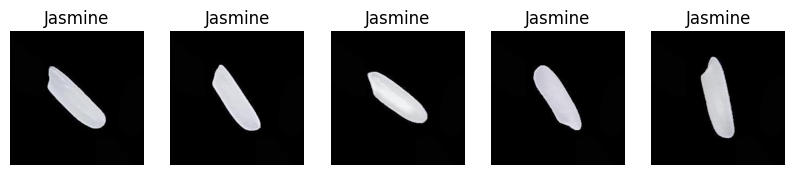

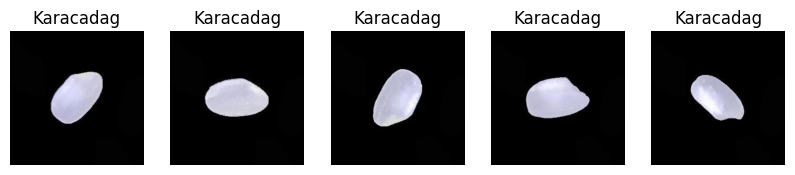

In [11]:
# Display a few example images from each class
for label in df['label'].unique():
    plt.figure(figsize=(10, 10))
    sample_images = df[df['label'] == label].sample(5)
    for i, image_path in enumerate(sample_images['image']):
        img = Image.open(image_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()


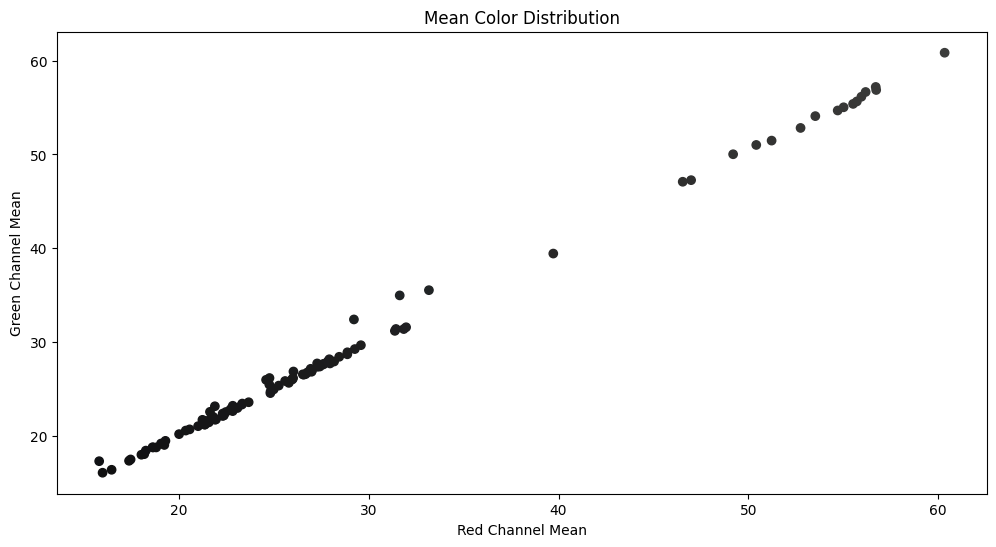

In [18]:
# Function to get mean color
def get_mean_color(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    return img.mean(axis=(0, 1))

# Get mean colors of a sample of images
sample_images = df.sample(100)['image']
mean_colors = np.array([get_mean_color(img) for img in sample_images])

# Plot mean colors
plt.figure(figsize=(12, 6))
plt.scatter(mean_colors[:, 0], mean_colors[:, 1], c=mean_colors / 255.0)
plt.title('Mean Color Distribution')
plt.xlabel('Red Channel Mean')
plt.ylabel('Green Channel Mean')
plt.show()

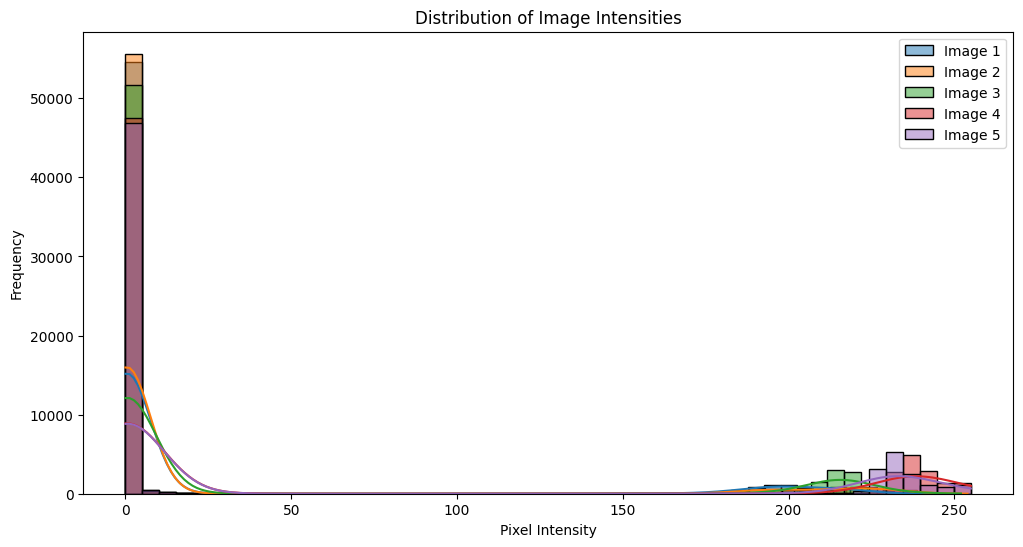

In [21]:
# Function to get image intensity distribution
def get_image_intensity(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(img).flatten()

# Get intensity distributions of a sample of images
sample_images = df.sample(100)['image']
intensity_distributions = np.array([get_image_intensity(img) for img in sample_images])

# Plot intensity distributions
plt.figure(figsize=(12, 6))
for i, intensity in enumerate(intensity_distributions[:5]):  # Plot first 5 images
    sns.histplot(intensity, bins=50, kde=True, label=f'Image {i+1}')
plt.title('Distribution of Image Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Vorverarbeitung der Daten

### Erkennen von Anomalien und Ausreißern

In [12]:
# Example code to check for corrupted images
for image_path in df['image']:
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, in fact, an image
    except (IOError, SyntaxError) as e:
        print(f"Bad file: {image_path}")



### Testen von Annahmen, Auswahl und Entwicklung von Merkmalen, Optimierung des Modellentwurfs, Erleichterung der Datenbereinigung, Verbesserung der Kommunikation

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [14]:
# Split the data into train (80%) and temp (20%) sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the temp set into validation (10%) and test (10%) sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f'Train set: {train_df.shape}')
print(f'Validation set: {val_df.shape}')
print(f'Test set: {test_df.shape}')

Train set: (60000, 3)
Validation set: (7500, 3)
Test set: (7500, 3)


# Datenaufteilung und Modelltraining

In [15]:
def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(size)
    img = np.array(img) / 255.0
    return img

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, size=(128, 128), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.size = size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.size, 3))
        y = np.empty((self.batch_size), dtype=int)
        for i, (image_path, label) in enumerate(zip(batch_df['image'], batch_df['label_encoded'])):
            X[i,] = preprocess_image(image_path, self.size)
            y[i] = label
        y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.classes_))
        return X, y

# Create data generators
train_generator = DataGenerator(train_df, batch_size=32)
val_generator = DataGenerator(val_df, batch_size=32)
test_generator = DataGenerator(test_df, batch_size=32)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

c:\Users\vae.tiolamon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\vae.tiolamon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 480s 255ms/step - accuracy: 0.9345 - loss: 0.1825 - val_accuracy: 0.9675 - val_loss: 0.0927
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 476s 254ms/step - accuracy: 0.9729 - loss: 0.0771 - val_accuracy: 0.9877 - val_loss: 0.0393
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 486s 259ms/step - accuracy: 0.9897 - loss: 0.0307 - val_accuracy: 0.9932 - val_loss: 0.0287
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 492s 262ms/step - accuracy: 0.9934 - loss: 0.0205 - val_accuracy: 0.9931 - val_loss: 0.0214
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 503s 268ms/step - accuracy: 0.9951 - loss: 0.0149 - val_accuracy: 0.9880 - val_loss: 0.0415
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 496s 264ms/step - accuracy: 0.9953 - loss: 0.0144 - val_accuracy: 0.9935 - val_loss: 0.0221
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 480s 256ms/step - accuracy: 0.9964 - loss: 0.0106 - val_accuracy: 0.9960 - val_loss: 0.0171
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 473s 252ms/step - accuracy: 0.9

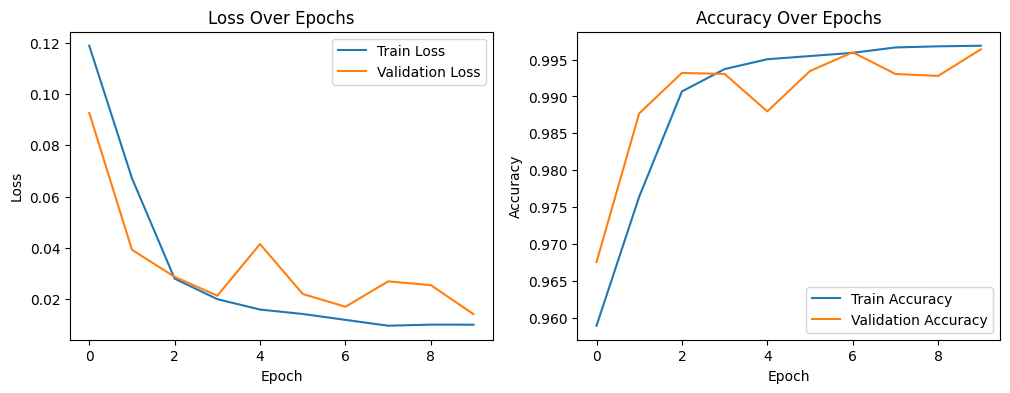

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Modellbewertung

In [31]:
# Evaluate the model
loss, cnn_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {cnn_accuracy}")



234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9968 - loss: 0.0072
Test Accuracy: 0.995726466178894


# Implementierung und Einsatz

In [32]:
# Navigate to your repository
!cd "C:\Users\Tristan\OneDrive\Documents\DHBW\dataex\MLsem4"

# Initialize Git LFS if not done already
!git lfs install
!git lfs track "*.keras"

# Add files
!git add .gitattributes reis_erkennung_gpt.ipynb rice_cnn_model.keras

# Commit your changes
!git commit -m "Add model file and resolve conflicts"

# Pull the latest changes
!git pull origin main

# Resolve conflicts if any, then add resolved files
# Open reis_erkennung_gpt.ipynb and edit to resolve conflicts
!git add reis_erkennung_gpt.ipynb

# Commit the resolution
!git commit -m "Resolve merge conflict in reis_erkennung_gpt.ipynb"

# Push changes to GitHub
!git push origin main


The system cannot find the path specified.


Updated Git hooks.
Git LFS initialized.
"*.keras" already supported
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Already up to date.


From https://github.com/Vae2002/MLsem4
 * branch                main       -> FETCH_HEAD


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Everything up-to-date


In [34]:
# Laden des Modells für den Einsatz
loaded_model = load_model('rice_cnn_model.keras')

In [35]:
# Prediction function
def predict_image(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = loaded_model.predict(img)
    predicted_class_idx = np.argmax(prediction)
    predicted_class_name = label_encoder.inverse_transform([predicted_class_idx])[0]
    return predicted_class_name

# Example prediction
sample_image_path = 'Ipsala.jpg'
predicted_class_name = predict_image(sample_image_path)
print(f'Predicted label: {predicted_class_name}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted label: Ipsala


# Modellvergleich

### Entscheidungsbaum-Modell

In [25]:
def load_and_flatten_image(image_path):
    img = Image.open(image_path).resize((128, 128))  # Consistent size
    img_array = np.array(img).flatten()
    return img_array

# Load and flatten images
train_images = np.array([load_and_flatten_image(img_path) for img_path in train_df['image']])
test_images = np.array([load_and_flatten_image(img_path) for img_path in test_df['image']])

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_df['label'])
test_labels = le.transform(test_df['label'])

# Train Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(train_images, train_labels)

# Predict and evaluate
dt_predictions = dt_model.predict(test_images)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.9370666666666667


### SVM

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(train_images, train_labels)

# Predict using the SVM model
svm_predictions = svm_model.predict(test_images)

# Calculate accuracy
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Accuracy: 0.9884


### Vergleich der Modelle

In [30]:
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"CNN Accuracy: {cnn_accuracy}")

SVM Accuracy: 0.9884
Decision Tree Accuracy: 0.9370666666666667
CNN Accuracy: 0.995726466178894
